# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [2]:
import pandas as pd
import numpy as np

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [173]:
# filename = './_flights_fix2.csv'
# df = pd.read_csv(filename, engine='c', low_memory=False)
# # update dtypes
# str_obj = ['mkt_unique_carrier', 'op_unique_carrier', 'origin_city_name', 'dest_city_name']
# date_obj = ['fl_date']
# id_obj = ['origin_airport_id', 'dest_airport_id']
# time_obj = ['crs_dep_time', 'dep_time', 'crs_arr_time', 'arr_time']
# # df[date_obj] = df[date_obj].astype(dtype='datetime64[ns]')
# df[date_obj] = df[date_obj].astype(dtype='string')
# df[str_obj] = df[str_obj].astype(dtype='string')
# df[id_obj] = df[id_obj].astype(dtype='int16')
# df.iloc[:, 7:] = df.iloc[:, 7:].astype(dtype='int16')
# # update time obj
# for t in time_obj:
#     df[t] = df[t].astype(dtype='string').str.zfill(4)
#     df[t].replace(to_replace={'2400': '0000'}, inplace=True)
#     df[t] = df['fl_date'] + df[t]
#     df[t] = pd.to_datetime(df[t], format='%Y-%m-%d%H%M', errors='coerce')
# df.info()

In [172]:
# df[(df['arr_delay'] > 0) & (df.iloc[:, 19:].sum(axis=1) == 0)].iloc[:, 9:].sort_values(by=['arr_delay'], ascending=False)
# _df = df[df['arr_delay'] > 0].copy()
# _df.insert(loc=19, column='traffic_delay', value=0)
# _df['traffic_delay'] = _df['actual_elapsed_time'] - _df['crs_elapsed_time']
# _df.iloc[:, 14:].sort_values(by=['traffic_delay'], ascending=False).head()

In [171]:
# dff = df[(df['arr_delay'] > 0) & (df.iloc[:, 19:].sum(axis=1) > 0)][
#     [
#         # 'fl_date',            # check_weather
#         'arr_delay',          # target value (y)
#         'mkt_unique_carrier', # category for avg_carrier_delay
#         'origin_airport_id',  # dep_weather
#         'origin_city_name',   # check_weather
#         'crs_dep_time',       # avg_dep_traffic / check_weather
#         'dest_airport_id',    # arr_weather
#         'dest_city_name',     # check_weather
#         'crs_arr_time',       # avg_arr_traffic / check_weather
#         # 'crs_elapsed_time',   # this one should work the same as distance, pick 1/2
#         'distance',           # this one should work the same as crs_elapsed_time, pick 1/2
#         'carrier_delay',      # avg_carrier_delay
#         'weather_delay',      # avg_extreme_weather_delay, based on weather info, should be 0 for most
#         'nas_delay',          # this relates to air_traffic and weather_effect
#         'security_delay',     # very minimal impact, drop column later
#         'late_aircraft_delay' # avg_late_aircraft_delay
#     ]
# ]
# dff.drop(index=dff[dff['security_delay'] > 0].index, inplace=True)
# dff.drop(columns=['security_delay'], inplace=True)
# dff.to_csv('./_flights_feat.csv', index=False)

In [3]:
filename = '../_flights_feat.csv'
df = pd.read_csv(filename, engine='c', low_memory=False)
# update dtypes
df.iloc[:, :1] = df.iloc[:, :1].astype(dtype='int16')
str_obj = ['mkt_unique_carrier', 'origin', 'dest']
time_obj = ['crs_dep_time', 'crs_arr_time']
df[str_obj] = df[str_obj].astype(dtype='string')
df[time_obj] = df[time_obj].astype(dtype='datetime64[ns]')
df.iloc[:, 6:] = df.iloc[:, 6:].astype(dtype='int16')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5407500 entries, 0 to 5407499
Data columns (total 13 columns):
 #   Column               Dtype         
---  ------               -----         
 0   arr_delay            int16         
 1   mkt_unique_carrier   string        
 2   origin               string        
 3   crs_dep_time         datetime64[ns]
 4   dest                 string        
 5   crs_arr_time         datetime64[ns]
 6   crs_elapsed_time     int16         
 7   actual_elapsed_time  int16         
 8   distance             int16         
 9   carrier_delay        int16         
 10  weather_delay        int16         
 11  nas_delay            int16         
 12  late_aircraft_delay  int16         
dtypes: datetime64[ns](2), int16(8), string(3)
memory usage: 288.8 MB


In [38]:
df.head()

,arr_delay,mkt_unique_carrier,origin,crs_dep_time,dest,crs_arr_time,crs_elapsed_time,actual_elapsed_time,distance,carrier_delay,weather_delay,nas_delay,late_aircraft_delay
0,38,DL,FLL,2018-07-30 12:42:00,ATL,2018-07-30 14:42:00,120,152,581,6,0,32,0
1,13,DL,MSP,2018-07-30 20:31:00,SFO,2018-07-30 22:50:00,259,274,1589,0,0,0,0
2,21,DL,MDW,2018-07-30 06:00:00,ATL,2018-07-30 08:49:00,109,128,591,0,0,21,0
3,6,DL,ALB,2018-07-30 18:15:00,ATL,2018-07-30 20:53:00,158,146,853,0,0,0,0
4,18,DL,ATL,2018-07-30 15:11:00,ALB,2018-07-30 17:35:00,144,149,853,0,0,18,0


In [46]:
# df[df['weather_delay'] >= 30].sort_values(by=['weather_delay']).head(10)
df['weather_delay'].describe()

count    5.407500e+06
mean     1.426102e+00
std      1.201950e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.990000e+02
Name: weather_delay, dtype: float64

In [8]:
df_ = df[
    # (df['crs_dep_time'].dt.month == 1) & (df['crs_dep_time'].dt.day <= 7)
    df['crs_dep_time'].dt.month == 1
].copy()
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403647 entries, 936476 to 4328681
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   arr_delay            403647 non-null  int16         
 1   mkt_unique_carrier   403647 non-null  string        
 2   origin               403647 non-null  string        
 3   crs_dep_time         403647 non-null  datetime64[ns]
 4   dest                 403647 non-null  string        
 5   crs_arr_time         403647 non-null  datetime64[ns]
 6   crs_elapsed_time     403647 non-null  int16         
 7   actual_elapsed_time  403647 non-null  int16         
 8   distance             403647 non-null  int16         
 9   carrier_delay        403647 non-null  int16         
 10  weather_delay        403647 non-null  int16         
 11  nas_delay            403647 non-null  int16         
 12  late_aircraft_delay  403647 non-null  int16         
dtypes: datet

In [9]:
df_['arr_delay'].describe()

count    403647.000000
mean         34.861721
std          46.422341
min           1.000000
25%           7.000000
50%          17.000000
75%          42.000000
max         299.000000
Name: arr_delay, dtype: float64

### <span style='color:magenta'> Airport(local) Weather </span>

In [79]:
_airports = pd.DataFrame(
    {
        # 'id': df.groupby(by=['origin_airport_id', 'origin_city_name']).count().index.get_level_values(0),
        # 'name': df.groupby(by=['origin_airport_id', 'origin_city_name']).count().index.get_level_values(1)
        'IATA': dff.groupby(by=['origin']).count().index
    }
)
# _airports.loc[_airports.iloc[:, 1].duplicated(keep=False)].sort_values(by=['name'])
_airports

,IATA
0,ABE
1,ABI
2,ABQ
3,ABR
4,ABY
...,...
358,XNA
359,YAK
360,YKM
361,YNG


In [153]:
airports = pd.read_csv('../airports.csv', engine='c', low_memory=False)
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71911 entries, 0 to 71910
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 71911 non-null  int64  
 1   ident              71911 non-null  object 
 2   type               71911 non-null  object 
 3   name               71911 non-null  object 
 4   latitude_deg       71911 non-null  float64
 5   longitude_deg      71911 non-null  float64
 6   elevation_ft       58312 non-null  float64
 7   continent          36843 non-null  object 
 8   iso_country        71652 non-null  object 
 9   iso_region         71911 non-null  object 
 10  municipality       66676 non-null  object 
 11  scheduled_service  71911 non-null  object 
 12  gps_code           42832 non-null  object 
 13  iata_code          9252 non-null   object 
 14  local_code         32649 non-null  object 
 15  home_link          3404 non-null   object 
 16  wikipedia_link     105

In [154]:
airports.drop(
    columns=[
        'id', 'ident', 'type',
        'continent', 'iso_country', 'iso_region', 'municipality',
        'scheduled_service', 'gps_code', 'local_code',
        'home_link', 'wikipedia_link', 'keywords'
    ],
    inplace=True
)
airports.iloc[:, :1] = airports.iloc[:, :1].astype(dtype='string')
airports.iloc[:, 1:4] = airports.iloc[:, 1:4].astype(dtype='float32')
airports.iloc[:, 4] = airports.iloc[:, 4].astype(dtype='string')
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71911 entries, 0 to 71910
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           71911 non-null  string 
 1   latitude_deg   71911 non-null  float32
 2   longitude_deg  71911 non-null  float32
 3   elevation_ft   58312 non-null  float32
 4   iata_code      9252 non-null   string 
dtypes: float32(3), string(2)
memory usage: 1.9 MB


In [155]:
airports.head()

,name,latitude_deg,longitude_deg,elevation_ft,iata_code
0,Total Rf Heliport,40.070801,-74.933601,11.0,<NA>
1,Aero B Ranch Airport,38.704021,-101.473907,3435.0,<NA>
2,Lowell Field,59.947735,-151.692520,450.0,<NA>
3,Epps Airpark,34.864799,-86.770302,820.0,<NA>
4,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,<NA>


In [165]:
# dff_city = pd.DataFrame(data=dff['origin'].values, columns=['IATA'])
lat = []
lon = []
for code in _airports['IATA']:
    lat.append(airports[airports['iata_code'] == code]['latitude_deg'].values[0])
    lon.append(airports[airports['iata_code'] == code]['longitude_deg'].values[0])
# dff_city.insert(loc=1, column='lat', value=lat)
# dff_city.insert(loc=2, column='lon', value=lon)
_airports.insert(loc=1, column='lat', value=lat)
_airports.insert(loc=2, column='lon', value=lon)

In [166]:
_airports.isnull().sum()

IATA    0
lat     0
lon     0
dtype: int64

In [167]:
_airports.head()

,IATA,lat,lon
0,ABE,40.651772,-75.442795
1,ABI,32.411301,-99.681900
2,ABQ,35.040199,-106.609001
3,ABR,45.449100,-98.421799
4,ABY,31.532946,-84.196213


In [ ]:
from meteostat import Point, Daily
from datetime import datetime

weather18w1 = []
for i in _airports.index:
    loc = Point(_airports.iloc[i, 1], _airports.iloc[i, 2])
    start = datetime(2018, 1, 1)
    end = datetime(2018, 1, 7)
    data = Daily(loc=loc, start=start, end=end)
    data = data.fetch()
    weather18w1.append(data)

### <span style='color:royalblue'> Feature Engineering </span>

In [10]:
dff = df_.copy()
# dff.drop(columns=['arr_delay'], inplace=True)
dff.head()

,arr_delay,mkt_unique_carrier,origin,crs_dep_time,dest,crs_arr_time,crs_elapsed_time,actual_elapsed_time,distance,carrier_delay,weather_delay,nas_delay,late_aircraft_delay
936476,58,DL,OMA,2018-01-01 08:15:00,DTW,2018-01-01 11:21:00,126,137,651,47,0,11,0
936477,23,DL,MSP,2018-01-01 15:05:00,BIS,2018-01-01 16:50:00,105,86,386,23,0,0,0
936478,28,DL,BNA,2018-01-01 07:00:00,MCO,2018-01-01 10:03:00,123,154,616,0,0,28,0
936479,20,DL,MCO,2018-01-01 10:38:00,BNA,2018-01-01 11:40:00,122,120,616,0,0,0,20
936480,67,DL,BOS,2018-01-01 13:20:00,JFK,2018-01-01 14:50:00,90,84,187,67,0,0,0


In [11]:
carrier_delay = dff.groupby(by='mkt_unique_carrier')['carrier_delay'].mean()
for i in carrier_delay.index:
    dff.loc[dff[dff['mkt_unique_carrier'] == i].index, ['carrier_delay']] = carrier_delay.loc[i]

dff['weather_delay'] += dff['nas_delay']
dff.drop(columns=['nas_delay'], inplace=True)
weather_delay = dff.groupby(by='origin')['weather_delay'].mean()
for i in weather_delay.index:
    dff.loc[dff[dff['origin'] == i].index, ['weather_delay']] = weather_delay.loc[i]

late_aircraft_delay = dff.groupby(by='origin')['late_aircraft_delay'].mean()
for i in late_aircraft_delay.index:
    dff.loc[dff[dff['origin'] == i].index, ['late_aircraft_delay']] = late_aircraft_delay.loc[i]

dff.head()

,arr_delay,mkt_unique_carrier,origin,crs_dep_time,dest,crs_arr_time,crs_elapsed_time,actual_elapsed_time,distance,carrier_delay,weather_delay,late_aircraft_delay
936476,58,DL,OMA,2018-01-01 08:15:00,DTW,2018-01-01 11:21:00,126,137,651,10.095979,12.669184,13.685801
936477,23,DL,MSP,2018-01-01 15:05:00,BIS,2018-01-01 16:50:00,105,86,386,10.095979,13.270658,8.634184
936478,28,DL,BNA,2018-01-01 07:00:00,MCO,2018-01-01 10:03:00,123,154,616,10.095979,11.223508,13.389918
936479,20,DL,MCO,2018-01-01 10:38:00,BNA,2018-01-01 11:40:00,122,120,616,10.095979,8.109836,12.284836
936480,67,DL,BOS,2018-01-01 13:20:00,JFK,2018-01-01 14:50:00,90,84,187,10.095979,14.735357,17.107649


In [12]:
_df = dff[[
    'arr_delay',
    'mkt_unique_carrier',
    'distance',
    'carrier_delay',
    'weather_delay',
    'late_aircraft_delay'
]].copy()
_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403647 entries, 936476 to 4328681
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   arr_delay            403647 non-null  int16  
 1   mkt_unique_carrier   403647 non-null  string 
 2   distance             403647 non-null  int16  
 3   carrier_delay        403647 non-null  float64
 4   weather_delay        403647 non-null  float64
 5   late_aircraft_delay  403647 non-null  float64
dtypes: float64(3), int16(2), string(1)
memory usage: 25.0 MB


In [13]:
_df.drop(
    index=_df[_df['mkt_unique_carrier'] == 'VX'].index,
    inplace=True
)
_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401851 entries, 936476 to 4328681
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   arr_delay            401851 non-null  int16  
 1   mkt_unique_carrier   401851 non-null  string 
 2   distance             401851 non-null  int16  
 3   carrier_delay        401851 non-null  float64
 4   weather_delay        401851 non-null  float64
 5   late_aircraft_delay  401851 non-null  float64
dtypes: float64(3), int16(2), string(1)
memory usage: 16.9 MB


In [14]:
target = _df['arr_delay'].copy()
target.info()

<class 'pandas.core.series.Series'>
Int64Index: 401851 entries, 936476 to 4328681
Series name: arr_delay
Non-Null Count   Dtype
--------------   -----
401851 non-null  int16
dtypes: int16(1)
memory usage: 3.8 MB


In [15]:
_df.drop(columns=['arr_delay'], inplace=True)
_df = pd.concat(
    [_df, pd.get_dummies(data=_df['mkt_unique_carrier'])],
    axis=1
)
_df.drop(columns=['mkt_unique_carrier'], inplace=True)
_df.head()

,distance,carrier_delay,weather_delay,late_aircraft_delay,AA,AS,B6,DL,F9,G4,HA,NK,UA,WN
936476,651,10.095979,12.669184,13.685801,0,0,0,1,0,0,0,0,0,0
936477,386,10.095979,13.270658,8.634184,0,0,0,1,0,0,0,0,0,0
936478,616,10.095979,11.223508,13.389918,0,0,0,1,0,0,0,0,0,0
936479,616,10.095979,8.109836,12.284836,0,0,0,1,0,0,0,0,0,0
936480,187,10.095979,14.735357,17.107649,0,0,0,1,0,0,0,0,0,0


### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [184]:
# tsclr = StandardScaler()
# target = tsclr.fit_transform(target)
# target.ravel()

In [18]:
_df1 = pd.DataFrame(data=StandardScaler().fit_transform(_df), columns=_df.columns)
_df1.head()

,distance,carrier_delay,weather_delay,late_aircraft_delay,AA,AS,B6,DL,F9,G4,HA,NK,UA,WN
0,-0.180202,0.603709,0.807668,0.112876,-0.632272,-0.226519,-0.225857,2.108944,-0.135842,-0.116544,-0.111196,-0.145117,-0.497035,-0.45423
1,-0.646712,0.603709,0.984350,-0.945639,-0.632272,-0.226519,-0.225857,2.108944,-0.135842,-0.116544,-0.111196,-0.145117,-0.497035,-0.45423
2,-0.241816,0.603709,0.383002,0.050877,-0.632272,-0.226519,-0.225857,2.108944,-0.135842,-0.116544,-0.111196,-0.145117,-0.497035,-0.45423
3,-0.241816,0.603709,-0.531635,-0.180682,-0.632272,-0.226519,-0.225857,2.108944,-0.135842,-0.116544,-0.111196,-0.145117,-0.497035,-0.45423
4,-0.997035,0.603709,1.414603,0.829890,-0.632272,-0.226519,-0.225857,2.108944,-0.135842,-0.116544,-0.111196,-0.145117,-0.497035,-0.45423


In [19]:
pca_model = PCA(n_components=10, svd_solver='full')
pca_model.fit(X=_df1)

PCA(n_components=10, svd_solver='full')

In [20]:
print(np.cumsum(pca_model.explained_variance_ratio_))

[0.17160685 0.282132   0.37796419 0.46831769 0.55027674 0.62853113
 0.70256423 0.77546984 0.84799014 0.90898116]


In [21]:
_df2 = pd.DataFrame(data=pca_model.transform(X=_df1), columns=[f'PCA{i}' for i in range(1, 11)])
_df2.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1.222444,-0.059776,0.295116,-2.132471,0.475343,0.076641,0.138094,0.006085,-0.044081,0.316806
1,0.926177,0.099512,0.190598,-2.405432,0.488519,0.300285,0.057365,-0.011379,-0.073554,0.196579
2,1.043006,0.107954,0.254934,-2.117066,0.452113,0.184632,0.149443,0.004090,-0.038679,0.319227
3,0.622229,0.556940,0.172683,-2.060476,0.442517,0.392550,0.182189,0.001788,-0.031800,0.430209
4,1.699071,-0.882411,0.320367,-2.319099,0.237056,0.095427,0.063998,-0.004977,-0.020619,-0.400315


### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(_df2, target, test_size=0.3)

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor().fit(X=X_train, y=y_train.ravel())

In [25]:
print('train_set_score', gb.score(X=X_train, y=y_train))
print('test_set_score', gb.score(X=X_test, y=y_test))

train_set_score 0.04412038192489143
test_set_score 0.04234945720557737


In [32]:
from sklearn.svm import LinearSVR
svm = LinearSVR(max_iter=10000).fit(X=X_train, y=y_train.ravel())

In [33]:
print('train_set_score', svm.score(X=X_train, y=y_train))
print('test_set_score', svm.score(X=X_test, y=y_test))

train_set_score -0.11146719102472447
test_set_score -0.10786252723391887


In [34]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X=X_train, y=y_train)

In [35]:
print('train_set_score', lr.score(X_train, y_train))
print('test_set_score', lr.score(X_test, y_test))

train_set_score 0.0355819912865325
test_set_score 0.03692967007587655


In [36]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_jobs=4).fit(X=X_train, y=y_train.ravel())

In [37]:
print('train_set_score', rfr.score(X=X_train, y=y_train))
print('test_set_score', rfr.score(X=X_test, y=y_test))
print('feature_importance', rfr.feature_importances_)

train_set_score 0.08845983233775034
test_set_score 0.03253797499337163
feature_importance [0.38675038 0.07497551 0.06936528 0.0586674  0.06577496 0.06657164
 0.05819036 0.05896071 0.07919403 0.08154972]


In [38]:
import xgboost
xgb = xgboost.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 7, alpha = 0.1).fit(X=X_train, y=y_train)

/home/chao/miniconda3/envs/lhl/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/chao/miniconda3/envs/lhl/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [39]:
print('train_set_score', xgb.score(X=X_train, y=y_train))
print('test_set_score', xgb.score(X=X_test, y=y_test))

train_set_score 0.06114049791232701
test_set_score 0.04844448383195232


/home/chao/miniconda3/envs/lhl/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

In [65]:
filename = '../flights_test.csv'
dft = pd.read_csv(filename, engine='c', low_memory=False)
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660556 entries, 0 to 660555
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   fl_date             660556 non-null  object
 1   mkt_unique_carrier  660556 non-null  object
 2   branded_code_share  660556 non-null  object
 3   mkt_carrier         660556 non-null  object
 4   mkt_carrier_fl_num  660556 non-null  int64 
 5   op_unique_carrier   660556 non-null  object
 6   tail_num            659057 non-null  object
 7   op_carrier_fl_num   660556 non-null  int64 
 8   origin_airport_id   660556 non-null  int64 
 9   origin              660556 non-null  object
 10  origin_city_name    660556 non-null  object
 11  dest_airport_id     660556 non-null  int64 
 12  dest                660556 non-null  object
 13  dest_city_name      660556 non-null  object
 14  crs_dep_time        660556 non-null  int64 
 15  crs_arr_time        660556 non-null  int64 
 16  du

In [67]:
dft['fl_date'] = pd.to_datetime(dft['fl_date'], errors='coerce')
dft.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance
0,2020-01-01,WN,WN,WN,5888,WN,N951WN,5888,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1810,1945,N,95,1,363
1,2020-01-01,WN,WN,WN,6276,WN,N467WN,6276,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1150,1320,N,90,1,363
2,2020-01-01,WN,WN,WN,4598,WN,N7885A,4598,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",2020,2130,N,70,1,333
3,2020-01-01,WN,WN,WN,4761,WN,N551WN,4761,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",1340,1455,N,75,1,333
4,2020-01-01,WN,WN,WN,5162,WN,N968WN,5162,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",915,1035,N,80,1,333


In [233]:
_filter = (dft['fl_date'].dt.month == 1) & (dft['fl_date'].dt.day <= 7)
dft_ = dft[_filter][[
    'mkt_unique_carrier',
    'origin',
    'distance',
]].copy()
dft_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150623 entries, 0 to 150622
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   mkt_unique_carrier  150623 non-null  object
 1   origin              150623 non-null  object
 2   distance            150623 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.6+ MB


In [234]:
dft_.insert(loc=3, column='carrier_delay', value=0)
dft_.insert(loc=4, column='weather_delay', value=0)
dft_.insert(loc=5, column='late_arrival_delay', value=0)
dft_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150623 entries, 0 to 150622
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   mkt_unique_carrier  150623 non-null  object
 1   origin              150623 non-null  object
 2   distance            150623 non-null  int64 
 3   carrier_delay       150623 non-null  int64 
 4   weather_delay       150623 non-null  int64 
 5   late_arrival_delay  150623 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 8.0+ MB


In [235]:
for i in carrier_delay.index:
    dft_.loc[dft_[dft_['mkt_unique_carrier'] == i].index, ['carrier_delay']] = carrier_delay.loc[i]

for i in weather_delay.index:
    dft_.loc[dft_[dft_['origin'] == i].index, ['weather_delay']] = weather_delay.loc[i]

for i in late_aircraft_delay.index:
    dft_.loc[dft_[dft_['origin'] == i].index, ['late_aircraft_delay']] = late_aircraft_delay.loc[i]

dft_.head()

,mkt_unique_carrier,origin,distance,carrier_delay,weather_delay,late_arrival_delay,late_aircraft_delay
0,WN,ONT,363,6.93863,8.682785,0,11.473888
1,WN,ONT,363,6.93863,8.682785,0,11.473888
2,WN,ONT,333,6.93863,8.682785,0,11.473888
3,WN,ONT,333,6.93863,8.682785,0,11.473888
4,WN,ONT,333,6.93863,8.682785,0,11.473888


In [236]:
dft_ = pd.concat(
    [dft_, pd.get_dummies(data=dft_['mkt_unique_carrier'])],
    axis=1
)
dft_.drop(columns=['mkt_unique_carrier', 'origin'], inplace=True)
dft_.head()

,distance,carrier_delay,weather_delay,late_arrival_delay,late_aircraft_delay,AA,AS,B6,DL,F9,G4,HA,NK,UA,WN
0,363,6.93863,8.682785,0,11.473888,0,0,0,0,0,0,0,0,0,1
1,363,6.93863,8.682785,0,11.473888,0,0,0,0,0,0,0,0,0,1
2,333,6.93863,8.682785,0,11.473888,0,0,0,0,0,0,0,0,0,1
3,333,6.93863,8.682785,0,11.473888,0,0,0,0,0,0,0,0,0,1
4,333,6.93863,8.682785,0,11.473888,0,0,0,0,0,0,0,0,0,1


In [239]:
dft_0 = dft_.drop(index=dft_.loc[dft_['late_aircraft_delay'].isnull()].index)
dft_0.isnull().sum()

distance               0
carrier_delay          0
weather_delay          0
late_arrival_delay     0
late_aircraft_delay    0
AA                     0
AS                     0
B6                     0
DL                     0
F9                     0
G4                     0
HA                     0
NK                     0
UA                     0
WN                     0
dtype: int64

In [243]:
dft_1 = pd.DataFrame(data=StandardScaler().fit_transform(dft_0), columns=dft_0.columns)
dft_1.head()

,distance,carrier_delay,weather_delay,late_arrival_delay,late_aircraft_delay,AA,AS,B6,DL,F9,G4,HA,NK,UA,WN
0,-0.717790,-0.973822,-0.319449,0.0,-0.312431,-0.601561,-0.244766,-0.196203,-0.501815,-0.142422,-0.1204,-0.110524,-0.167387,-0.499084,2.236443
1,-0.717790,-0.973822,-0.319449,0.0,-0.312431,-0.601561,-0.244766,-0.196203,-0.501815,-0.142422,-0.1204,-0.110524,-0.167387,-0.499084,2.236443
2,-0.768273,-0.973822,-0.319449,0.0,-0.312431,-0.601561,-0.244766,-0.196203,-0.501815,-0.142422,-0.1204,-0.110524,-0.167387,-0.499084,2.236443
3,-0.768273,-0.973822,-0.319449,0.0,-0.312431,-0.601561,-0.244766,-0.196203,-0.501815,-0.142422,-0.1204,-0.110524,-0.167387,-0.499084,2.236443
4,-0.768273,-0.973822,-0.319449,0.0,-0.312431,-0.601561,-0.244766,-0.196203,-0.501815,-0.142422,-0.1204,-0.110524,-0.167387,-0.499084,2.236443


In [244]:
pca_model = PCA(n_components=10, svd_solver='full')
pca_model.fit(X=dft_1)
print(np.cumsum(pca_model.explained_variance_ratio_))

[0.17089992 0.27673226 0.37124134 0.46299105 0.54632012 0.62563304
 0.69981096 0.77284262 0.8454784  0.90888482]


In [245]:
dft_2 = pd.DataFrame(data=pca_model.transform(X=dft_1), columns=[f'PCA{i}' for i in range(1, 11)])
dft_2.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,-1.641038,-0.083237,0.636725,-0.662459,-1.875556,-0.638027,-0.267268,-0.027010,-0.075850,-0.351066
1,-1.641038,-0.083237,0.636725,-0.662459,-1.875556,-0.638027,-0.267268,-0.027010,-0.075850,-0.351066
2,-1.640811,-0.099146,0.628352,-0.678620,-1.890007,-0.625663,-0.269360,-0.027458,-0.074435,-0.380564
3,-1.640811,-0.099146,0.628352,-0.678620,-1.890007,-0.625663,-0.269360,-0.027458,-0.074435,-0.380564
4,-1.640811,-0.099146,0.628352,-0.678620,-1.890007,-0.625663,-0.269360,-0.027458,-0.074435,-0.380564


In [246]:
ypred_t = xgb.predict(X=dft_2)

/home/chao/miniconda3/envs/lhl/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [249]:
print(len(ypred_t))
ypred_t = np.round(ypred_t)
ypred_t

150396


array([27., 27., 27., ..., 29., 39., 50.], dtype=float32)

In [253]:
df_sub = dft[_filter][[
    'fl_date', 'mkt_carrier', 'mkt_carrier_fl_num', 'origin', 'dest'
]]
df_sub.drop(index=dft_.loc[dft_['late_aircraft_delay'].isnull()].index, inplace=True)
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150396 entries, 0 to 150622
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   fl_date             150396 non-null  datetime64[ns]
 1   mkt_carrier         150396 non-null  object        
 2   mkt_carrier_fl_num  150396 non-null  int64         
 3   origin              150396 non-null  object        
 4   dest                150396 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 6.9+ MB


In [254]:
df_sub.insert(
    loc=5,
    column='predicted_delay',
    value=np.int16(ypred_t)
)
df_sub.head()

,fl_date,mkt_carrier,mkt_carrier_fl_num,origin,dest,predicted_delay
0,2020-01-01,WN,5888,ONT,SFO,27
1,2020-01-01,WN,6276,ONT,SFO,27
2,2020-01-01,WN,4598,ONT,SJC,27
3,2020-01-01,WN,4761,ONT,SJC,27
4,2020-01-01,WN,5162,ONT,SJC,27


In [257]:
df_sub['predicted_delay'].describe()

count    150396.000000
mean         34.917272
std           7.417329
min          20.000000
25%          29.000000
50%          34.000000
75%          40.000000
max          89.000000
Name: predicted_delay, dtype: float64

In [255]:
df_sub.to_csv('./submission_CSi.csv', index=False)

In [48]:
_x = [
'dep_delay',
'crs_elapsed_time',
'nas_delay',
'late_aircraft_delay',
'carrier_delay',
'passengers',
'capacity',
'origin_airport_id',
'dest_airport_id',
'distance',
'total_gallons',
'weather_delay',
'security_delay'
]

In [49]:
_y = [
0.220665,
0.182979,
0.090361,
0.068881,
0.065717,
0.063864,
0.061855,
0.059212,
0.058391,
0.049645,
0.042902,
0.029439,
0.006089
]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'dep_delay'),
  Text(1, 0, 'crs_elapsed_time'),
  Text(2, 0, 'nas_delay'),
  Text(3, 0, 'late_aircraft_delay'),
  Text(4, 0, 'carrier_delay'),
  Text(5, 0, 'passengers'),
  Text(6, 0, 'capacity'),
  Text(7, 0, 'origin_airport_id'),
  Text(8, 0, 'dest_airport_id'),
  Text(9, 0, 'distance'),
  Text(10, 0, 'total_gallons'),
  Text(11, 0, 'weather_delay'),
  Text(12, 0, 'security_delay')])

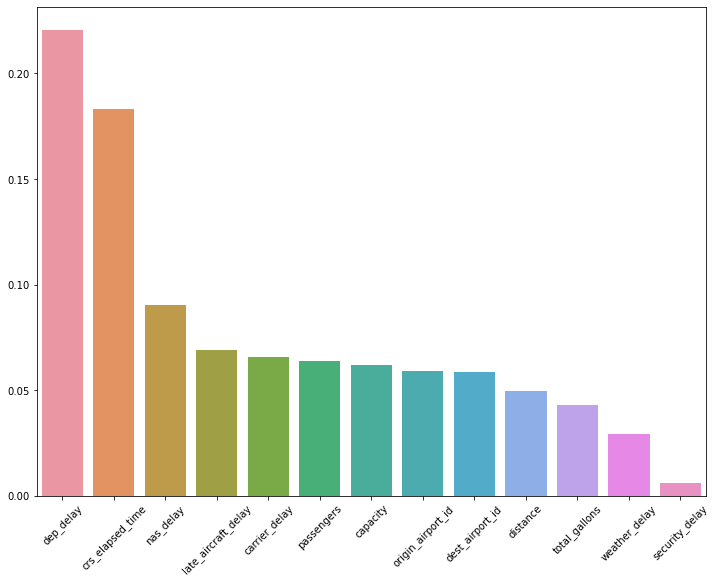

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 9))
sns.barplot(x=_x, y=_y)
plt.xticks(rotation=45)

In [61]:
jfk = df[(df['crs_dep_time'].dt.month == 1) & (df['crs_dep_time'].dt.day == 1) & (df['origin'] == 'JFK')].copy()

In [67]:
jfk_traffic = jfk.groupby(by=df['crs_dep_time'].dt.hour)['arr_delay'].count().values
jfk.groupby(by=df['crs_dep_time'].dt.hour)['arr_delay'].count()

crs_dep_time
5      5
6      9
7     15
8     20
9     16
10    14
11    24
12     9
13    20
14    11
15    22
16    15
17    13
18    15
19    21
20    18
21    11
22    10
23     2
Name: arr_delay, dtype: int64

In [65]:
jfk_traffic

array([ 5,  9, 15, 20, 16, 14, 24,  9, 20, 11, 22, 15, 13, 15, 21, 18, 11,
       10,  2])

In [68]:
jfk_delay = jfk.groupby(by=df['crs_dep_time'].dt.hour)['arr_delay'].mean().values
jfk_delay

array([48.8       , 63.66666667, 57.13333333, 27.85      , 69.1875    ,
       34.        , 33.66666667, 72.88888889, 35.05      , 26.81818182,
       45.68181818, 27.6       , 30.92307692, 53.46666667, 51.38095238,
       25.83333333, 35.36363636, 64.6       , 20.        ])

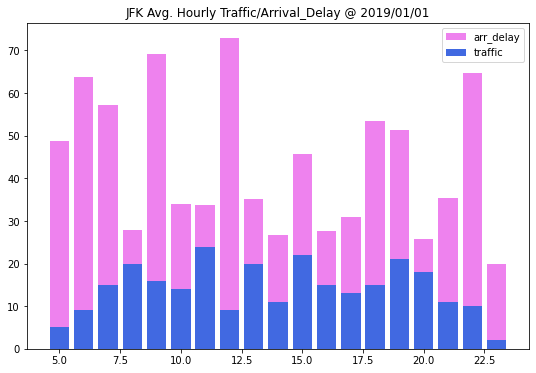

In [77]:
plt.figure(figsize=(9, 6))
plt.bar(
    x=range(5, 24),
    height=jfk_delay,
    color='violet',
    label='arr_delay'
)
plt.bar(
    x=range(5, 24),
    height=jfk_traffic,
    color='royalblue',
    label='traffic'
)
plt.title('JFK Avg. Hourly Traffic/Arrival_Delay @ 2019/01/01')
plt.legend()
plt.show()

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.